In [6]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
import ast
import logging
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import os

In [7]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

# Define constants
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-5
MODEL_NAME = 'xlm-roberta-base'

# Define possible labels
LABEL_COLUMNS = ['normal', 'harassment', 'dangerous_content', 'hate_speech', 'sexaully_explixit']


In [8]:
# Cell 4: Define utility classes
class TextCleaner:
    @staticmethod
    def clean_text(text):
        if isinstance(text, str):
            # Remove URLs
            text = re.sub(r'https?://\S+|www\.\S+', '', text)
            # Remove HTML tags
            text = re.sub(r'<.*?>', '', text)
            # Remove extra whitespaces
            text = re.sub(r'\s+', ' ', text).strip()
            return text
        return ""

class FacebookDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.cleaner = TextCleaner()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.cleaner.clean_text(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

In [9]:
# Cell 5: Define model architecture
class MultiLabelClassifier(nn.Module):
    def __init__(self, num_labels):
        super(MultiLabelClassifier, self).__init__()
        self.num_labels = num_labels
        self.roberta = XLMRobertaModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        # Use CLS token representation for classification
        cls_output = sequence_output[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits

In [10]:
# Cell 6: Define data preprocessing function
def preprocess_dataframe(df_path):
    logger.info(f"Loading dataset from {df_path}")
    df = pd.read_csv(df_path)

    # Convert string representation of lists to actual lists and handle multi-labels
    logger.info("Processing labels")

    # Initialize label columns with zeros
    for label in LABEL_COLUMNS:
        df[label] = 0

    # Process each row's label
    for idx, row in df.iterrows():
        try:
            # Parse the string representation of list into an actual list
            labels = ast.literal_eval(row['label'])

            # Set corresponding label columns to 1
            for label in labels:
                label = label.strip()
                if label in LABEL_COLUMNS:
                    df.at[idx, label] = 1
        except (ValueError, SyntaxError) as e:
            logger.warning(f"Error parsing label at index {idx}: {e}")

    # Drop unnecessary columns and handle missing values
    df = df.drop(['Unnamed: 0', 'id', 'label'], axis=1)
    df = df.fillna({'text': ''})

    return df

In [11]:
# Cell 7: Define helper functions for training and evaluation
def calculate_class_weights(labels):
    """Calculate class weights for imbalanced dataset"""
    pos_weights = []
    for i in range(labels.shape[1]):
        # Count number of positive and negative samples for each class
        neg_count = len(labels) - np.sum(labels[:, i])
        pos_count = np.sum(labels[:, i])
        # Calculate positive weight
        weight = neg_count / pos_count if pos_count > 0 else 1.0
        pos_weights.append(weight)
    return torch.FloatTensor(pos_weights).to(device)

def train_model(model, train_loader, val_loader, epochs, optimizer, scheduler, class_weights):
    """Train the model"""
    # Loss function with class weights for imbalanced dataset
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

    best_val_f1 = 0
    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}

    for epoch in range(epochs):
        logger.info(f"Epoch {epoch + 1}/{epochs}")

        # Training phase
        model.train()
        train_losses = []

        for batch in tqdm(train_loader, desc="Training"):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        history['train_loss'].append(avg_train_loss)
        logger.info(f"Train Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_losses = []
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs, labels)

                val_losses.append(loss.item())

                # Convert logits to predictions (threshold at 0.5)
                preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
                all_preds.extend(preds.astype(int))
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = np.mean(val_losses)
        val_f1 = f1_score(np.array(all_labels), np.array(all_preds), average='weighted')

        history['val_loss'].append(avg_val_loss)
        history['val_f1'].append(val_f1)

        logger.info(f"Val Loss: {avg_val_loss:.4f}, Val F1: {val_f1:.4f}")

        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pt')
            logger.info("Saved best model checkpoint")

    return history


In [12]:
# Cell 8: Define visualization and evaluation functions
def plot_training_history(history):
    """Plot training and validation metrics"""
    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation F1 score
    plt.subplot(1, 2, 2)
    plt.plot(history['val_f1'], label='Validation F1')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def evaluate_model(model, test_loader, class_names):
    """Evaluate the model on the test set"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Convert logits to predictions
            preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
            all_preds.extend(preds.astype(int))
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    logger.info(f"Accuracy: {accuracy:.4f}")

    # Print classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    logger.info("Classification Report:\n" + report)

    return accuracy, report

In [13]:
# Cell 9: Define prediction function
def predict(model, tokenizer, text, max_len=128):
    """Make prediction for a single text input"""
    cleaner = TextCleaner()
    cleaned_text = cleaner.clean_text(text)

    # Tokenize the text
    encoding = tokenizer(
        cleaned_text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=True,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Move tensors to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Set model to evaluation mode
    model.eval()

    # Get predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.sigmoid(outputs).cpu().numpy() > 0.5

    # Convert to list of predicted labels
    predicted_labels = []
    for i, pred in enumerate(predictions[0]):
        if pred:
            predicted_labels.append(LABEL_COLUMNS[i])

    return predicted_labels, outputs.cpu().numpy()[0]

In [14]:
df = preprocess_dataframe('facebook_comment_2k7 - facebook_comment_2k7.csv')
logger.info(f"Dataset shape after preprocessing: {df.shape}")

In [15]:
# Prepare labels and features
X = df['text'].values
y = df[LABEL_COLUMNS].values

# Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

logger.info(f"Training set size: {len(X_train)}")
logger.info(f"Validation set size: {len(X_val)}")
logger.info(f"Test set size: {len(X_test)}")

In [16]:
# Cell 12: Create datasets and data loaders
# Initialize tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)

# Create datasets
train_dataset = FacebookDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = FacebookDataset(X_val, y_val, tokenizer, MAX_LEN)
test_dataset = FacebookDataset(X_test, y_test, tokenizer, MAX_LEN)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [17]:
# Cell 13: Initialize model and training components
# Initialize model
model = MultiLabelClassifier(len(LABEL_COLUMNS))
model = model.to(device)

# Calculate class weights for loss function
class_weights = calculate_class_weights(y_train)

# Prepare optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
# Cell 14: Train the model
# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    scheduler=scheduler,
    class_weights=class_weights
)


Validation: 100%|██████████| 26/26 [02:25<00:00,  5.58s/it]


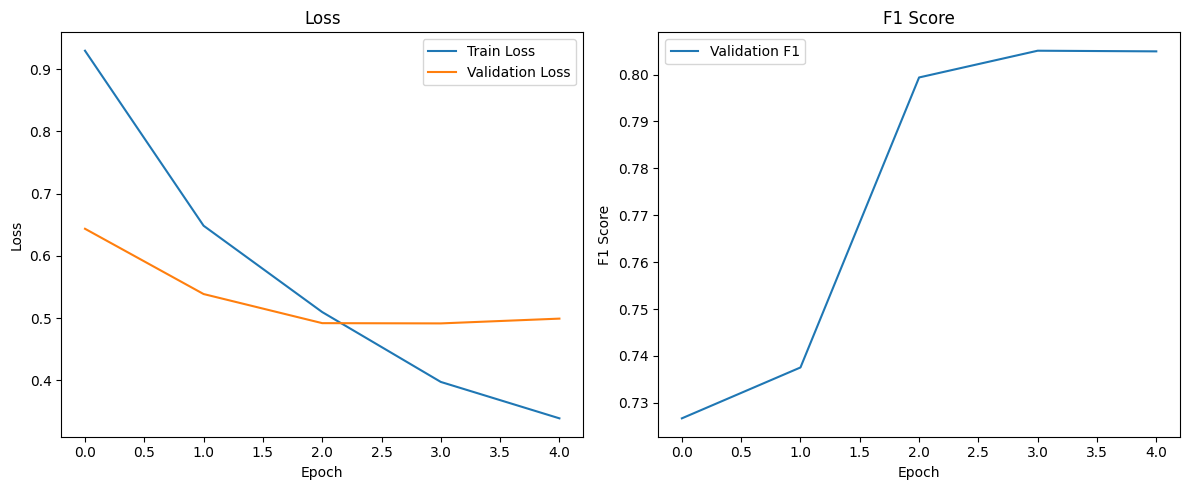

In [19]:
# Cell 15: Visualize training history
# Plot training history
plot_training_history(history)

In [20]:
# Cell 16: Evaluate the model
# Load best model for evaluation
model.load_state_dict(torch.load('best_model.pt'))

# Evaluate the model
accuracy, report = evaluate_model(model, test_loader, LABEL_COLUMNS)
print(f"Final Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

Testing: 100%|██████████| 26/26 [02:51<00:00,  6.59s/it]

Final Accuracy: 0.6815
Classification Report:
                   precision    recall  f1-score   support

           normal       0.92      0.90      0.91       245
       harassment       0.29      0.83      0.43        29
dangerous_content       0.95      0.90      0.92        39
      hate_speech       0.69      0.91      0.79        79
sexaully_explixit       0.45      0.70      0.55        30

        micro avg       0.73      0.88      0.80       422
        macro avg       0.66      0.85      0.72       422
     weighted avg       0.80      0.88      0.83       422
      samples avg       0.78      0.88      0.81       422




/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
# Cell 17: Test model with sample predictions
# Example of making predictions with the trained model
sample_texts = [
    "This is a normal comment about the weather.",
    "I hate you and your entire family, you should die!",
    "Check out these dangerous substances for sale",
    "Here are explicit sexual details that shouldn't be shared",
    "Phạm Thu Tuyết sang năm 2020 chúc nyc bị địt nhiều 😂😂😃",
    "Cụ bà said: biết thế k đẻ ra thằng bố nó để giờ ra nông nổi này. Thậy đúng là đẻ con dại thì thảm hại cái l*n:)"
]

print("Making predictions on sample texts:")
for text in sample_texts:
    predicted_labels, confidence_scores = predict(model, tokenizer, text)
    print(f"Text: {text}")
    print(f"Predicted labels: {predicted_labels}")
    print(f"Confidence scores: {confidence_scores}")
    print("-" * 50)


Making predictions on sample texts:
Text: This is a normal comment about the weather.
Predicted labels: ['normal']
Confidence scores: [ 2.1934943 -2.1378348 -2.0547051 -2.7948658 -2.4174092]
--------------------------------------------------
Text: I hate you and your entire family, you should die!
Predicted labels: ['normal', 'dangerous_content']
Confidence scores: [ 0.55107874 -2.2519612   0.22635412 -1.3818346  -3.0193052 ]
--------------------------------------------------
Text: Check out these dangerous substances for sale
Predicted labels: ['normal', 'dangerous_content']
Confidence scores: [ 0.17127953 -3.2662902   1.9640303  -3.1861265  -2.9887786 ]
--------------------------------------------------
Text: Here are explicit sexual details that shouldn't be shared
Predicted labels: ['sexaully_explixit']
Confidence scores: [-2.1227384 -2.7797997 -2.5615668 -1.4048533  4.907953 ]
--------------------------------------------------
Text: Phạm Thu Tuyết sang năm 2020 chúc nyc bị địt nhi